# TIme series analysis on sales data

## Get data

In [608]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy.optimize as optimize
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn import cross_validation
from sklearn.kernel_ridge import KernelRidge
from scipy.optimize import curve_fit
%matplotlib inline

In [609]:
data_path = 'simulated_sales.csv'

In [610]:
df = pd.read_csv(data_path)

In [611]:
df.head()

,sales,temp,week,tv_grps,radio_grps,digital_grps
0,2002.037282,1.204759,1,0,0,0
1,2013.473062,2.391967,2,0,0,0
2,2005.055256,3.544331,3,0,0,0
3,2004.756832,4.645062,4,0,0,0
4,2017.549066,5.678127,5,0,0,0


## Visualization

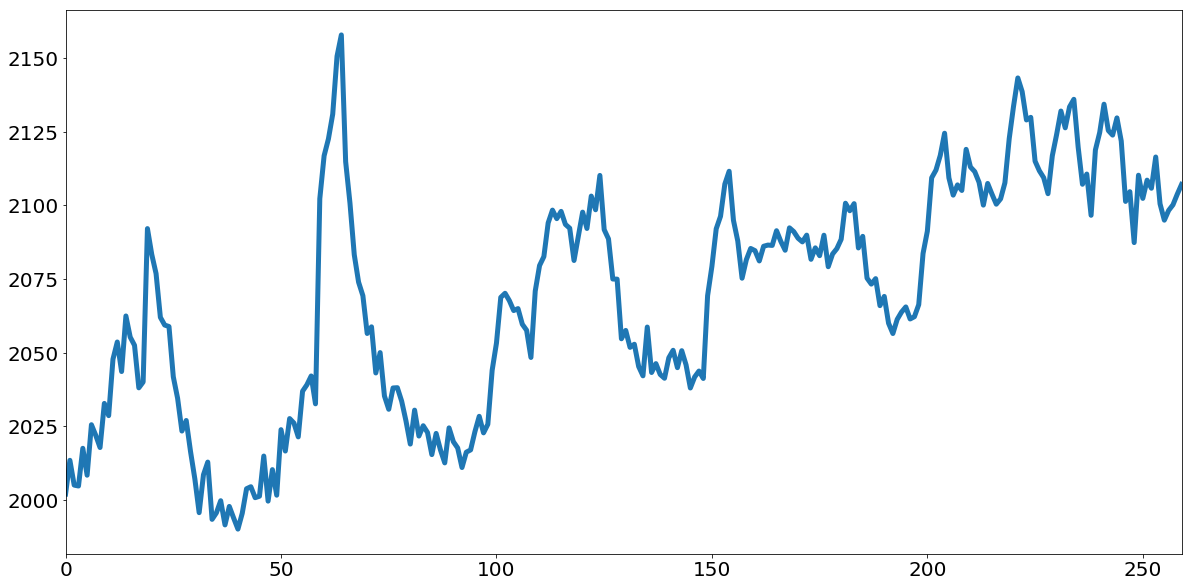

In [612]:
df['sales'].plot(figsize=(20,10), linewidth=5, fontsize=20)

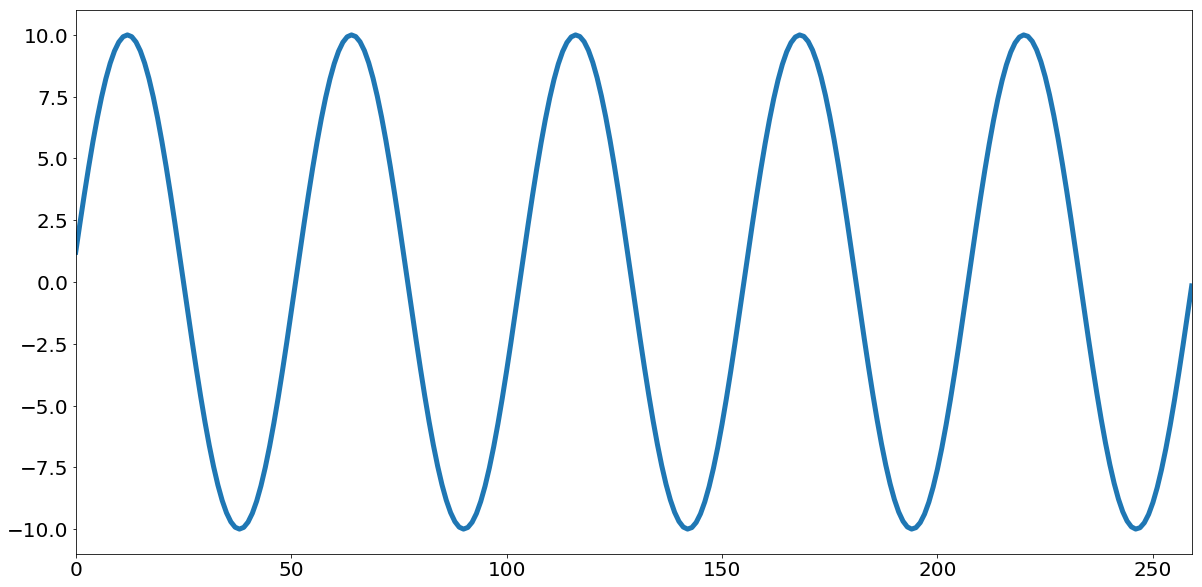

In [613]:
df['temp'].plot(figsize=(20,10), linewidth=5, fontsize=20)

## Modifying dataset

Add twenty previous values of GRPs as new columns to df

In [614]:
def add_shift_columns(df):
    for i in range(-20, 0):
        names = ["tv_grps","radio_grps","digital_grps"]
        for n in names:
            df[n + str(i)] = df[n].shift(abs(i))
    df2 = df.fillna(0).astype('float64')
    return df2

Divide the dataset into training and testing sets

In [615]:
def div_train_test(df, div):
    size = df.shape[0]
    training = df[:(size * div/10)]
    testing = df[(size * div/10):]
    return (training, testing)

In [616]:
df = add_shift_columns(df)
train, test = div_train_test(df, 8)

In [617]:
X_train = train.loc[:, train.columns != 'sales']
y_train = train['sales']
X_test= test.loc[:, test.columns != 'sales']
y_test = test['sales']

## Functions to be used

Mean Square error

In [618]:
def mse(df):
    columns = df.columns
    return ((df[columns[0]] - df[columns[1]]) ** 2).mean()

## Model

Different regression models to be used. I did not understand well how SVR and KernelRidge works so I did not spend too much time in optimizing them

In [619]:
models = [
    [LinearRegression(), {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}],
    [SVR(), {'kernel': ['rbf'], 'gamma': [0.5, 0,6, 0.7, 0.8, 0.9]}],
    [KernelRidge(), {'alpha': [0.001, 0.002]}]
]

Results

109.206512335
3311.74967677
2107051.37


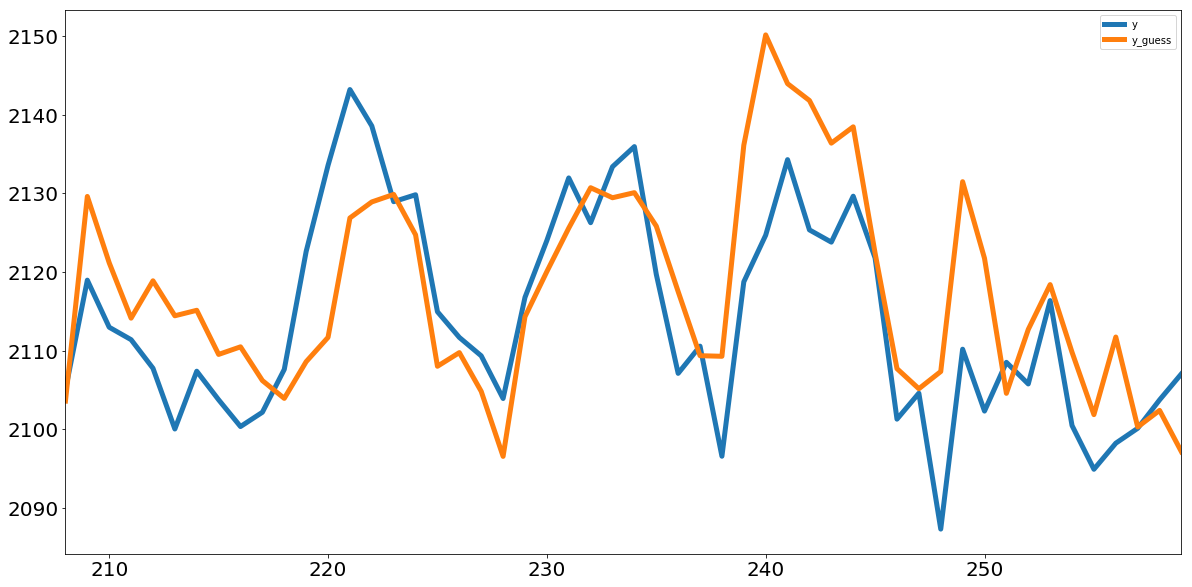

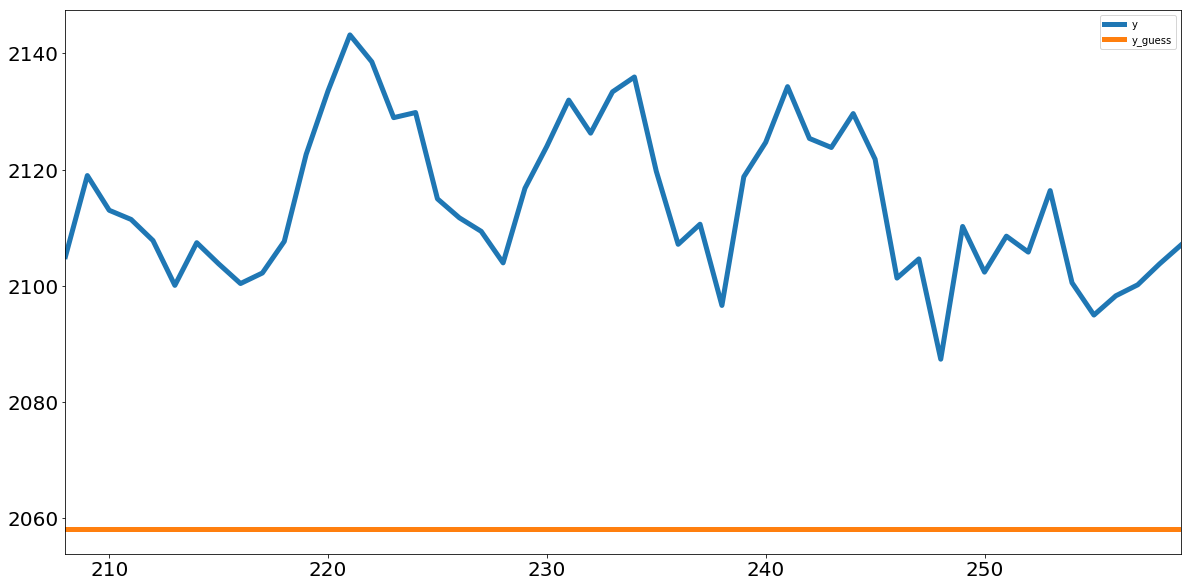

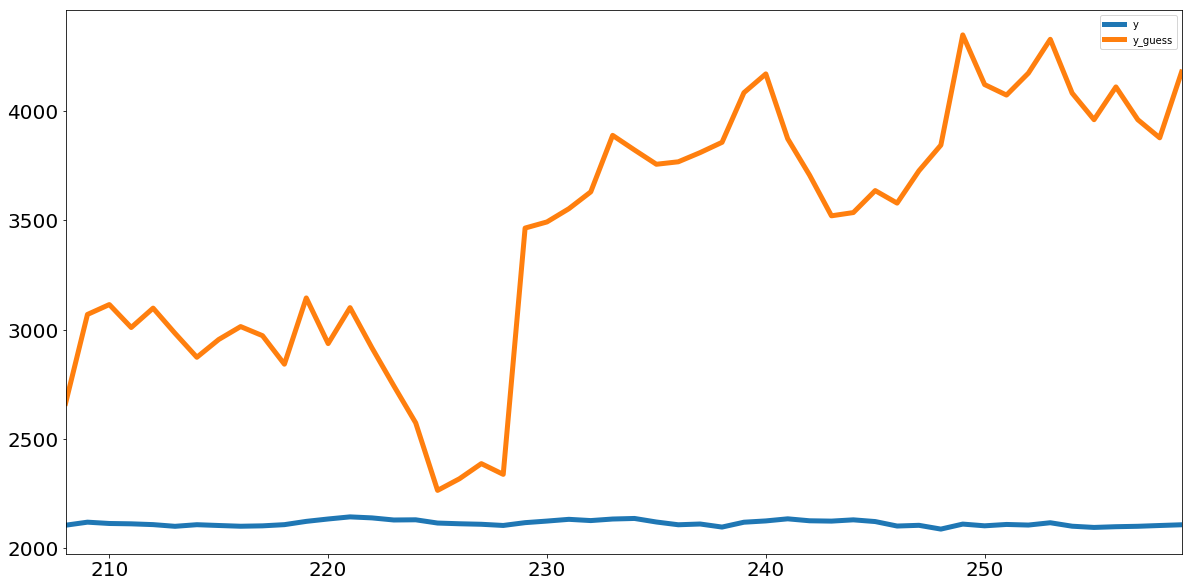

In [620]:
for m in models:
    model = m[0]
    p_dict = m[1]
    clf = GridSearchCV(model, p_dict)
    clf.fit(X_train,y_train).score(X_test,y_test)
    y_guess = clf.predict(X_test)
    d = {"y": y_test, "y_guess":y_guess}
    results = pd.DataFrame(data=d)
    print(mse(results))
    results.plot(figsize=(20,10), linewidth=5, fontsize=20)

## Model 2 - Moifying GRP values

In the previous model I used only linear optimization. For this the diminishing effect of advertising adstock is not present. In the following model I did a crude estimation for the diminishing effect of advertising adstock, before putting the values to the optimizer

Function for calculating the sales change in each GRPS

In [621]:

def grps_increase(column):
    active_rows = df[df[column] != 0]
    grps = active_rows[column]
    indexes = active_rows.index.values
    sales_dif = df.ix[indexes]['sales'].values - df.ix[indexes - 1]['sales'].values
    return (grps, sales_dif)

Loagrtihmic function, to describe the diminishing effect

In [622]:
def log_func(X, p0, p1, p2):
    log_x = np.array([x if x == 0 else math.log(float(x)) for x in X])
    result = log_x / math.log(p2) * p1 + p0
    return result

In [623]:
grps = ['tv_grps', 'radio_grps', 'digital_grps']

In [624]:
def log_params(grps):
    for g in grps:
        grps_values, sales = grps_increase(g)
        popt, pcov = curve_fit(log_func, grps_values, sales, bounds=(0, [1, 2, 5]))

Print parameter values, that will be used for grps log function

In [625]:
for g in grps:
    grps_values, sales = grps_increase(g)
    popt, pcov = curve_fit(log_func, grps_values, sales, bounds=(0, [1, 2, 5]))
    print(popt)

[  3.67607903e-16   1.29513422e+00   1.79851272e+00]
[  1.27402149e-12   1.12942824e+00   2.17653945e+00]
[  5.56614849e-12   1.20046946e+00   2.04308845e+00]


/Users/eerolehtonen/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [626]:
tv_params = [3.67607903e-16,1.29513422e+00,1.79851272e+00]
rd_params = [1.27402149e-12,1.12942824e+00,2.17653945e+00]
dg_params = [5.56614849e-12,1.20046946e+00,2.04308845e+00]

Create new dataframe where GRPS values have been changed to logarithmic function estimations

In [627]:
df_with_curve = pd.read_csv(data_path)
df_with_curve['tv_grps'] =  log_func(df_with_curve['tv_grps'].values, *tv_params)
df_with_curve['radio_grps'] =  log_func(df_with_curve['radio_grps'].values, *rd_params)
df_with_curve['digital_grps'] =  log_func(df_with_curve['digital_grps'].values, *dg_params)

In [628]:
df_with_curve.head()

,sales,temp,week,tv_grps,radio_grps,digital_grps
0,2002.037282,1.204759,1,3.676079e-16,1.274021e-12,5.566148e-12
1,2013.473062,2.391967,2,3.676079e-16,1.274021e-12,5.566148e-12
2,2005.055256,3.544331,3,3.676079e-16,1.274021e-12,5.566148e-12
3,2004.756832,4.645062,4,3.676079e-16,1.274021e-12,5.566148e-12
4,2017.549066,5.678127,5,3.676079e-16,1.274021e-12,5.566148e-12


Add previous weeks GRPS transformations and divide data to train/test

In [629]:
df_with_curve = add_shift_columns(df_with_curve)
train, test = div_train_test(df_with_curve, 8)

In [630]:
X_train = train.loc[:, train.columns != 'sales']
y_train = train['sales']
X_test= test.loc[:, test.columns != 'sales']
y_test = test['sales']

Run with different models

In [631]:
models = [
    [Ridge(), {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False], 'alpha':[0.05, 0.1, 0.15, 0.2, 0.25, 0.3]}], 
    [LinearRegression(), {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}],
    [SVR(), {'kernel': ['rbf'], 'gamma': [0.5, 0,6, 0.7, 0.8, 0.9]}],
    [KernelRidge(), {'alpha': [0.001, 0.002]}]
]

# [KernelRidge(), {'alpha': [0.5, 1]}],
#[Ridge(), {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False], 'alpha':[0.05, 0.1, 0.15, 0.2, 0.25, 0.3]}], 
#[LinearRegression(), {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}],

28.8017038442
44.8380688454
3311.74967677
1979883.04076


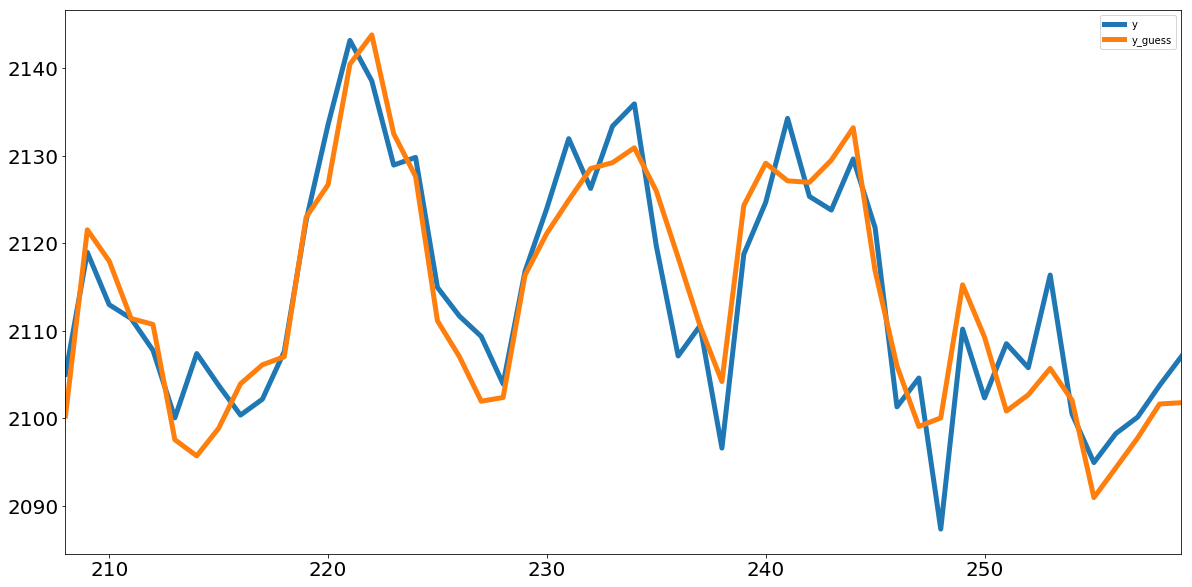

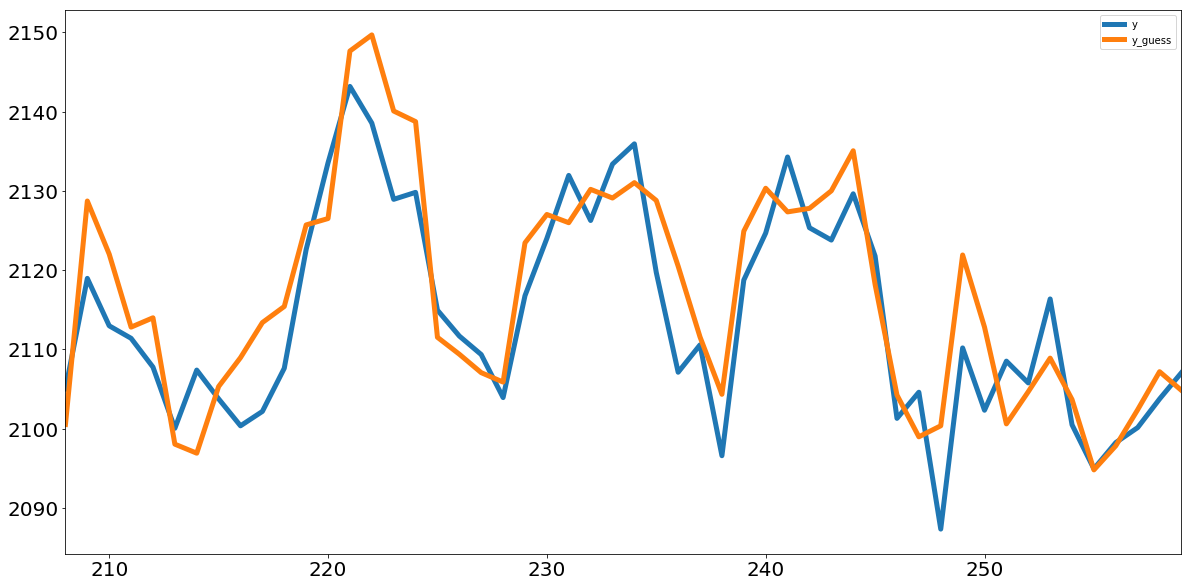

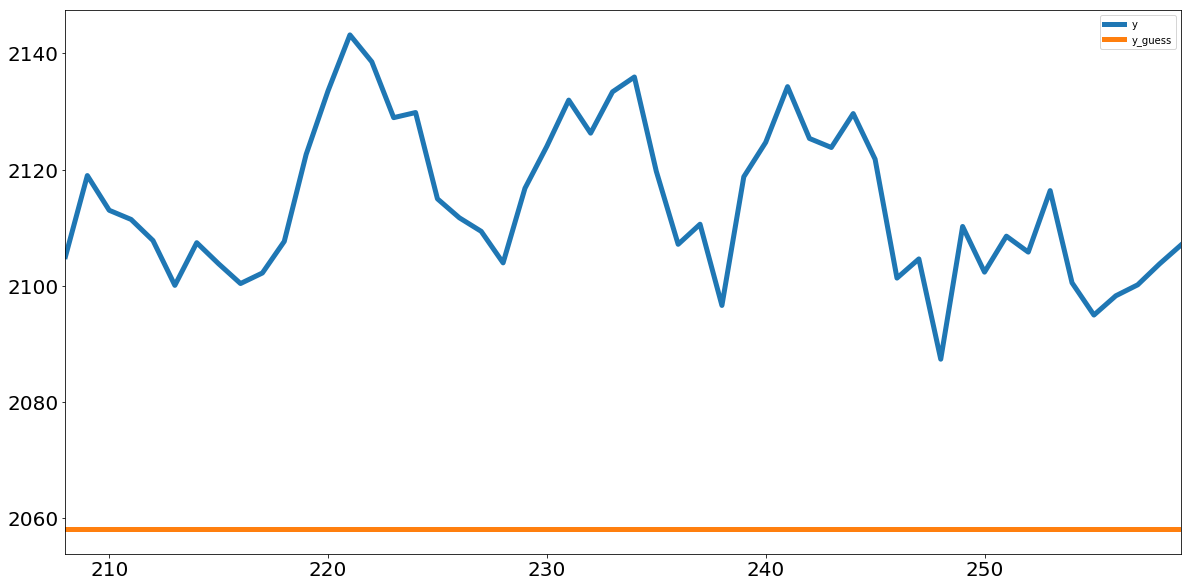

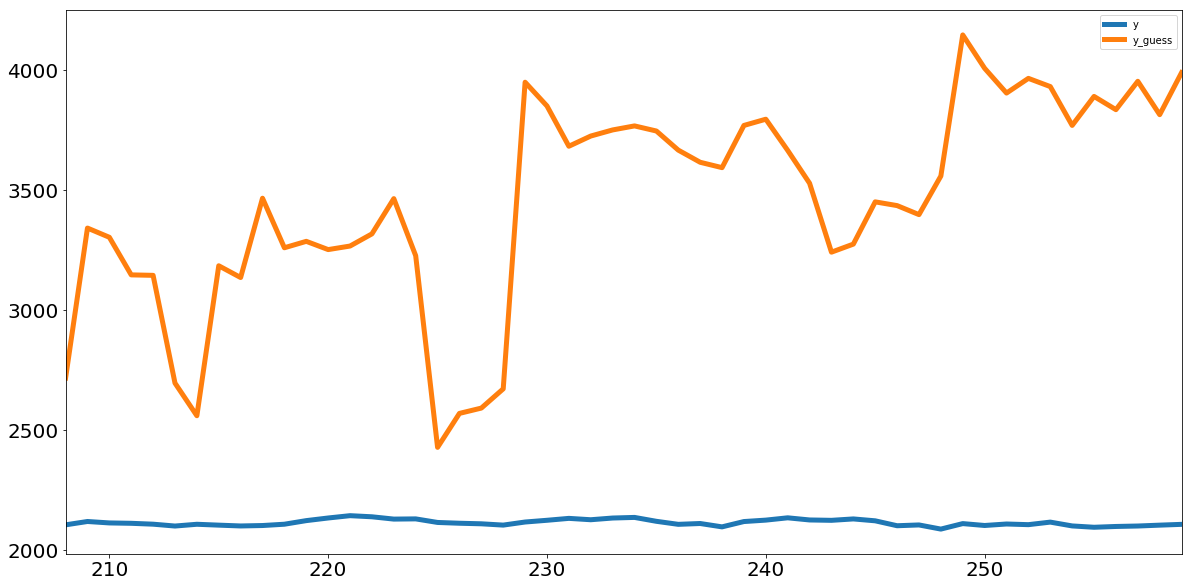

In [632]:
for m in models:
    model = m[0]
    p_dict = m[1]
    clf = GridSearchCV(model, p_dict)
    clf.fit(X_train,y_train).score(X_test,y_test)
    y_guess = clf.predict(X_test)
    d = {"y": y_test, "y_guess":y_guess}
    results = pd.DataFrame(data=d)
    print(mse(results))
    results.plot(figsize=(20,10), linewidth=5, fontsize=20)

## Results

1. The smallest testing error I was able to get with my Model 2, which used linear regression combibed with logistic optimization of the GRPS values. The testing error (mse) was 28.8
